# Analysis Script for Keys Online 
🐝
First we import the different Python libraries:

In [174]:
import os
import sys
import json
import re
import csv
import pprint
import numpy as np
randn = np.random.randn
from numpy import nan
import pandas as pd 
from pandas import *
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib
import scipy.stats as ss 
from scipy import stats, integrate

import seaborn as sns
sns.set(color_codes=True)

np.random.seed(sum(map(ord, "distributions")))



## Input information & set up data storage
Input participant numbers and location of folders. 

Invoke dictionary for data 

In [3]:
#Change this to whatever you need
input_dir = "/Users/Alex/Documents/Javascript_truecolours/Keys_Orienting/parsed/"
partno = [38, 37, 36, 35, 34, 33, 32, 30, 29, 28, 27, 25, 24, 23, 21, 20, 19, 18, 17, 16, 15, 14]
output_dir = "/Users/Alex/Documents/Javascript_truecolours/Keys_Orienting/results/"

#acknowledge directory
os.chdir(input_dir)
workingdirectory = input_dir

# This generates the empty dictionary in the desired nested format 
data = {}
for part in partno: 
    data[part] ={}
    for block in range(7): 
        data[part][block] = {}

## Read in data from CSV files 

Each session is read in as a panda.DataFrame in to the data dictionary, this gives the following structure:

    data[partno][blockno].field[trial]

So if I wanted to access participant 33, block 6 I would enter:

    data[33][6][0]
    
If I wanted just the image number in the first trial:

    data[33][6].image[0]

In [4]:
#Now we read in the actual CSV files: if data is missing it will be recorded as NaN
for part in partno:
    for block in range(10):
        
        try:
            #Reads the CSV file as a panda DataFrame into the Dict at the right location
            data[part][block] = pd.read_csv(input_dir + str(part) + '_' + str(block+1) + '.csv')
            #The parsing script sometimes makes empty files, with just headers. The line below checks if there is data in the read in CSV
            data[part][block].rename(columns= lambda x: x.replace(" ", ""), inplace=True)
            data[part][block]['image'][0]
        except:
            #if an exception is raised, the file does not exist or is corrupted 
            data[part][block] = {nan}


## Display a summary of the data 

We now need to return how complete each participants data is, we do this using the matplotlib


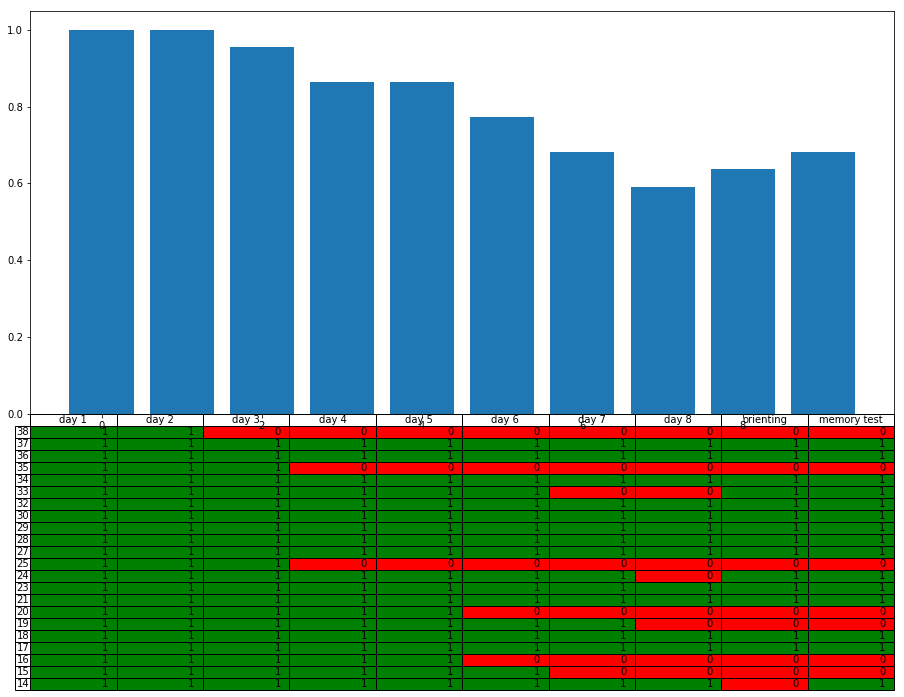

In [5]:
#Make a dataframe: participants x 10 blocks, set to 0
summary_mat = [[0 for x in range(10)] for y in range(len(data))]

#Loop through matrix and insert #1 if data is present
mt_cnt = 0
for part in partno:
    for block in range(10):
        #see if this block has more than one row of trial data
        try:
            data[part][block][:1]
            summary_mat[mt_cnt][block] = 1 
        except:
            pass
    mt_cnt +=1

#make the table
# define labels for columns and rows
columns = ('day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7', 'day 8', 'orienting', 'memory test')
rows = list(map(str, partno))
pads = matplotlib.figure.SubplotParams(left = 0.2, right = 1, bottom = 0.2, top = 1, wspace = 1, hspace = 1)
the_table = plt.figure(figsize=(15,7), subplotpars=pads)
#plot out the bar chart
the_table = plt.bar(range(10),  list((np.array(summary_mat)).mean(axis=0)))


#Make map for cell colours in the table (green = complete, red = absent)
cellcolours = np.empty_like(summary_mat, dtype='object')# empty array for colours
for r in range(len(summary_mat)): # loop through rows
    for c in range(len(summary_mat[0])): #loop through columns
        if summary_mat[r][c] == 1: #if data exists
            cellcolours[r,c] = 'g'
        else:                      #else there is not data
            cellcolours[r][c] = 'r'

#plot out the table 
the_table = plt.table(cellText=summary_mat,colLabels=columns, rowLabels=rows, cellColours=cellcolours)

#print the plot 
plt.show()



## Look at the training data 

Now let's look at how well the participants learnt each image in each order condition over the duration of training. 

We want to still include the participants with missing days so NaN this

In [6]:
data = pd.DataFrame(data)
rts = {}
rts_all = {}
#populate empty array
for day in range(8):
    rts[day] = {}
    rts_all[day] = {}
    for order in range(4):
        rts[day][order] = []
        rts_all[day][order] = []

#print(data[part][day](data[part][day]['correct'] == 1) & (data[part][day]['order']==1))
#append rows to array - exception if non existent (i.e. missing days)
for part in partno:
    for day in range(8):
        try:
            #only use correct trials 
            rts[day][0].append(np.array(data[part][day][(data[part][day]['order'] == 1) & (data[part][day]['correct'] == 1)]))
            rts[day][1].append(np.array(data[part][day][(data[part][day]['order'] == 2) & (data[part][day]['correct'] == 1)]))
            rts[day][2].append(np.array(data[part][day][(data[part][day]['order'] == 3) & (data[part][day]['correct'] == 1)]))
            rts[day][3].append(np.array(data[part][day][(data[part][day]['order'] == 4) & (data[part][day]['correct'] == 1)]))

            #use all trials 
            rts_all[day][0].append(np.array(data[part][day][data[part][day]['order'] == 1]))          
            rts_all[day][1].append(np.array(data[part][day][data[part][day]['order'] == 2]))
            rts_all[day][2].append(np.array(data[part][day][data[part][day]['order'] == 3]))
            rts_all[day][3].append(np.array(data[part][day][data[part][day]['order'] == 4]))
        except:
            pass 
        
#concat vertically all data in cells for each dayXcondition
for day in range(8):
    for order in range(4):
        rts[day][order] = np.vstack(rts[day][order])
        rts_all[day][order] = np.vstack(rts_all[day][order])

### RT Across Training 

Graph for looking at RT across training

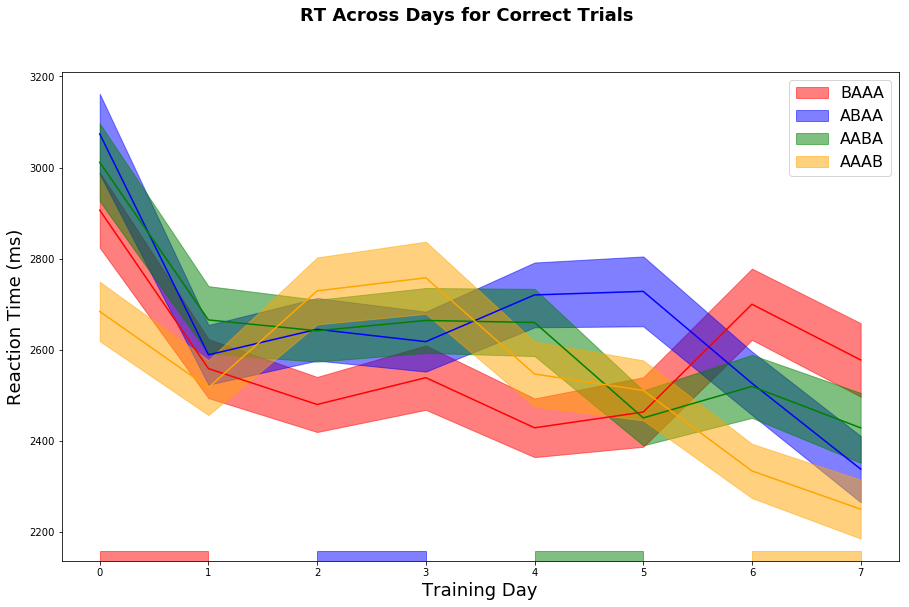

In [7]:
#make an array of means and SD (day x condition)   
means = np.zeros((8,4))
sd = np.zeros((8,4))
for day in range(8):
    for order in range(4):
        means[day, order] = np.mean(rts[day][order][:,5])#average RT
        sd[day, order] = ss.sem(rts[day][order][:,5])#Standard Error of the Mean 
        
#Plot the graph
rt_training = plt.figure(figsize=(15,9))
rt_training = plt.plot(range(len(means[:,0])), means[:,0], color = 'red')
rt_training = plt.fill_between(range(len(means[:,0])),means[:,0]-sd[:,0], means[:,0]+sd[:,0], alpha=0.5, color = 'red')
rt_training = plt.axvspan(0, 1, ymin=0, ymax=0.02, alpha = 0.5, color = 'red', zorder=0)
rt_training = plt.plot(means[:,1], color = 'blue')
rt_training = plt.fill_between(range(len(means[:,1])),means[:,1]-sd[:,1], means[:,1]+sd[:,1], alpha=0.5, color = 'blue')
rt_training = plt.axvspan(2, 3, ymin=0, ymax=0.02, alpha = 0.5, color = 'blue', zorder=0)
rt_training = plt.plot(means[:,2], color = 'green')
rt_training = plt.fill_between(range(len(means[:,2])),means[:,2]-sd[:,2], means[:,2]+sd[:,2], alpha=0.5, color = 'green')
rt_training = plt.axvspan(4, 5, ymin=0, ymax=0.02, alpha = 0.5, color = 'green', zorder=0)
rt_training = plt.plot(means[:,3], color = 'orange')
rt_training = plt.fill_between(range(len(means[:,3])),means[:,3]-sd[:,3], means[:,3]+sd[:,3], alpha=0.5, color = 'orange')
rt_training = plt.axvspan(6, 7, ymin=0, ymax=0.02, alpha = 0.5, color = 'orange', zorder=0)

#custom colour patches
red_patch = mpatches.Patch(color='red', label='BAAA', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='ABAA', alpha=0.5)
green_patch = mpatches.Patch(color='green', label='AABA', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='AAAB', alpha=0.5)

#Add legend to the plot: custom patches with manual text size                             
rt_training = plt.legend(handles=[red_patch, blue_patch, green_patch, orange_patch], prop={'size':16})

#Axis labels and plot title
rt_training = plt.ylabel('Reaction Time (ms)', fontsize=18)
rt_training = plt.xlabel('Training Day', fontsize=18)
rt_training = plt.suptitle('RT Across Days for Correct Trials', fontsize=18, fontweight='bold')
#show the plot 
plt.show()

### Accuracy Across Days 

Graph for accuracy across training 

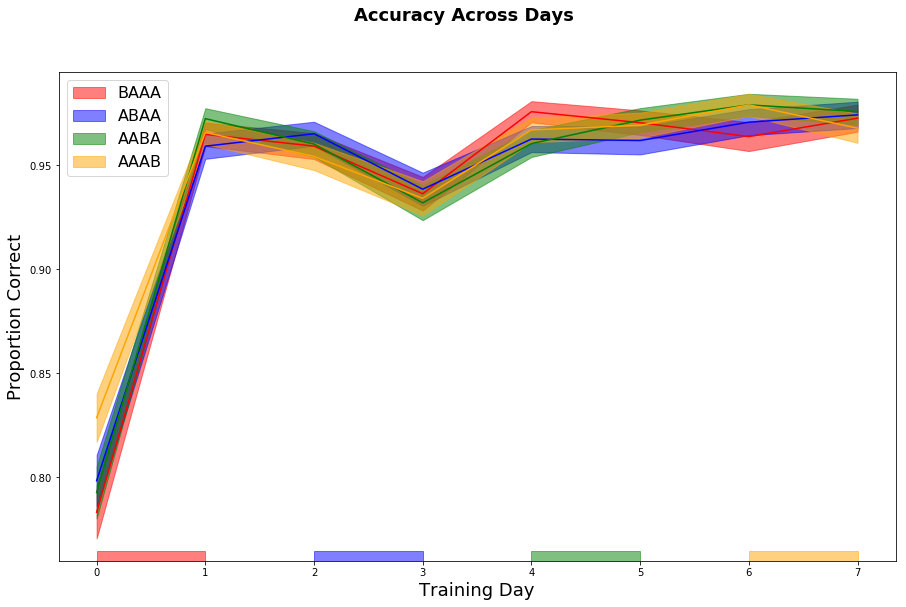

In [8]:
#make an array of means and SD (day x condition)   
means = np.zeros((8,4))
sd = np.zeros((8,4))
for day in range(8):
    for order in range(4):
        means[day, order] = np.mean(rts_all[day][order][:,8])#average RT
        sd[day, order] = ss.sem(rts_all[day][order][:,8])#Standard Error of the Mean 
        
#Plot the graph
rt_training = plt.figure(figsize=(15,9))
rt_training = plt.plot(range(len(means[:,0])), means[:,0], color = 'red')
rt_training = plt.fill_between(range(len(means[:,0])),means[:,0]-sd[:,0], means[:,0]+sd[:,0], alpha=0.5, color = 'red')
rt_training = plt.axvspan(0, 1, ymin=0, ymax=0.02, alpha = 0.5, color = 'red', zorder=0)
rt_training = plt.plot(means[:,1], color = 'blue')
rt_training = plt.fill_between(range(len(means[:,1])),means[:,1]-sd[:,1], means[:,1]+sd[:,1], alpha=0.5, color = 'blue')
rt_training = plt.axvspan(2, 3, ymin=0, ymax=0.02, alpha = 0.5, color = 'blue', zorder=0)
rt_training = plt.plot(means[:,2], color = 'green')
rt_training = plt.fill_between(range(len(means[:,2])),means[:,2]-sd[:,2], means[:,2]+sd[:,2], alpha=0.5, color = 'green')
rt_training = plt.axvspan(4, 5, ymin=0, ymax=0.02, alpha = 0.5, color = 'green', zorder=0)
rt_training = plt.plot(means[:,3], color = 'orange')
rt_training = plt.fill_between(range(len(means[:,3])),means[:,3]-sd[:,3], means[:,3]+sd[:,3], alpha=0.5, color = 'orange')
rt_training = plt.axvspan(6, 7, ymin=0, ymax=0.02, alpha = 0.5, color = 'orange', zorder=0)

#custom colour patches
red_patch = mpatches.Patch(color='red', label='BAAA', alpha=0.5)
blue_patch = mpatches.Patch(color='blue', label='ABAA', alpha=0.5)
green_patch = mpatches.Patch(color='green', label='AABA', alpha=0.5)
orange_patch = mpatches.Patch(color='orange', label='AAAB', alpha=0.5)

#Add legend to the plot: custom patches with manual text size                             
rt_training = plt.legend(handles=[red_patch, blue_patch, green_patch, orange_patch], prop={'size':16})

#Axis labels and plot title
rt_training = plt.ylabel('Proportion Correct', fontsize=18)
rt_training = plt.xlabel('Training Day', fontsize=18)
rt_training = plt.suptitle('Accuracy Across Days', fontsize=18, fontweight='bold')
#show the plot 
plt.show()

## Orienting Results 

Now let's look at the data from the orienting task. 

First we are going to do some pretty non-pythonic messing around with data structure (I am still learning).

In [161]:
#populate empty array - there was errors doing it in a more sensible way - first plotting script so lets see
orient= {}
all_orient= {}
for cond in range(2):
    orient[cond]= {}
    all_orient[cond]= {}
    for order in range(4):
        orient[cond][order]= []
        all_orient[cond][order]= []

#append rows to array - exception if non existent (i.e. missing days)
for part in partno:
        try:
            #only use correct trials 
            orient[0][0].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 1)]))
            orient[0][1].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 2)]))
            orient[0][2].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 3)]))
            orient[0][3].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 1) & (data[part][8]['order'] == 4)]))
            orient[1][0].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 1)]))
            orient[1][1].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 2)]))
            orient[1][2].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 3)]))
            orient[1][3].append(np.array(data[part][8][(data[part][8]['correctdirection'] == 1) & (data[part][8]['condition'] == 2) & (data[part][8]['order'] == 4)]))
            #all trials 
            all_orient[0][0].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 1) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[0][1].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 2) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[0][2].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 3) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[0][3].append(np.array(data[part][8][(data[part][8]['condition'] == 1) & (data[part][8]['order'] == 4) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][0].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 1) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][1].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 2) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][2].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 3) & (data[part][8]['correctdirection'] != 9)]))
            all_orient[1][3].append(np.array(data[part][8][(data[part][8]['condition'] == 2) & (data[part][8]['order'] == 4) & (data[part][8]['correctdirection'] != 9)]))
        except:
            pass 
        
#concat vertically all data in cells for each dayXcondition
for cond in range(2):
    for order in range(4):
        orient[cond][order] = np.vstack(orient[cond][order])
        all_orient[cond][order] = np.vstack(all_orient[cond][order])
        
# covert to DF because nested structure is actually a dict, which is not indexable by slices
orient = pd.DataFrame(orient)
all_orient = pd.DataFrame(all_orient)

### RT for conditions and order 

This will be two plots - one with RT by condition for all order, and one for condition x order. MATPLOTLIB with subplots. 

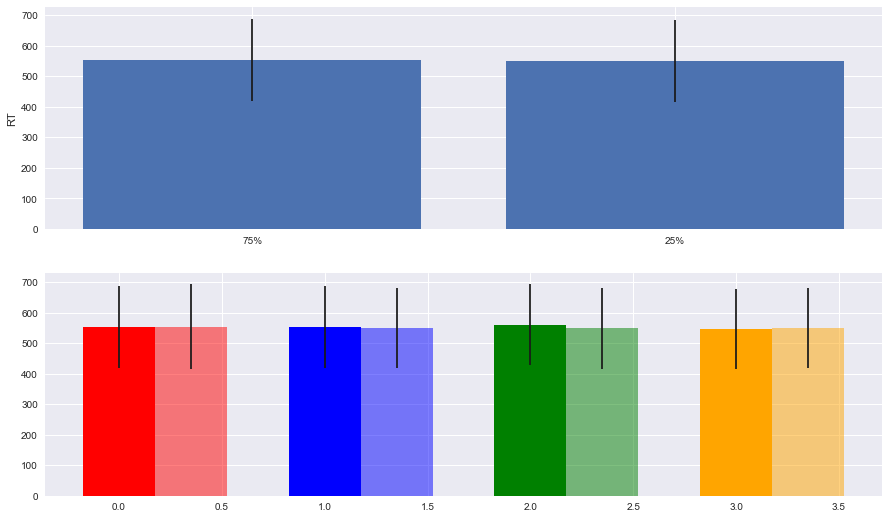

In [219]:
#Takes Means and Standard Error. 
#Due to the nested structure of orient (cond1[order1,2,3,4], cond2[order1,2,3,4]]) we have concat using np.vstack
cond_mean = np.array([np.mean(np.vstack(orient[0][:])[:,5]), np.mean(np.vstack(orient[1][:])[:,5])])
cond_error = np.array([np.std(np.vstack(orient[0][:])[:,5]), np.std(np.vstack(orient[1][:])[:,5])])

#make 2D array for this one. 2x4; condition x order
condxorder_mean = np.array([[np.mean(orient[0][0][:,5]), np.mean(orient[0][1][:,5]), np.mean(orient[0][2][:,5]), np.mean(orient[0][3][:,5])], [np.mean(orient[1][0][:,5]), np.mean(orient[1][1][:,5]), np.mean(orient[1][2][:,5]), np.mean(orient[1][3][:,5])]])
condxorder_error = np.array([[np.std(orient[0][0][:,5]), np.std(orient[0][1][:,5]), np.std(orient[0][2][:,5]), np.std(orient[0][3][:,5])], [np.std(orient[1][0][:,5]), np.std(orient[1][1][:,5]), np.std(orient[1][2][:,5]), np.std(orient[1][3][:,5])]])

f, rt_orient = plt.subplots(2, sharey=True, figsize=(15,9))

#First subplot - by condition
rt_orient[0].bar(range(len(cond_mean)), cond_mean*1000, 0.8, yerr = cond_error*1000)
rt_orient[0].set(ylabel="RT", xticks = np.arange(len(cond_mean)), xticklabels = ('75%', '25%'))

#second subplot - condition x order 
color_scheme = ['red', 'blue', 'green', 'orange']
rt_orient[1].bar(range(len(condxorder_mean[0])), condxorder_mean[0]*1000, 
                0.35, yerr = condxorder_error[0]*1000, label = '75%', color = color_scheme)
rt_orient[1].bar(np.arange(len(condxorder_mean[1])) + 0.35, condxorder_mean[1]*1000, 
                0.35, yerr = condxorder_error[1]*1000, label = '25%', color = color_scheme, alpha =0.5)
plt.show()

#### Distribution of RTs 
Using Seaborn let's quickly plot some distributions 


/Users/Alex/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


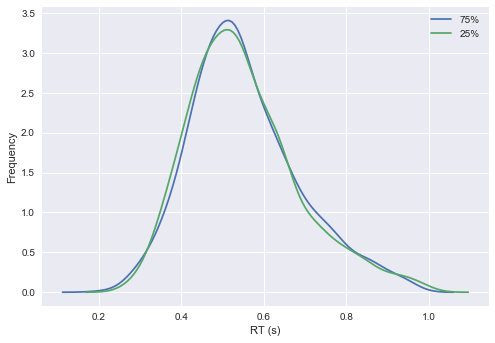

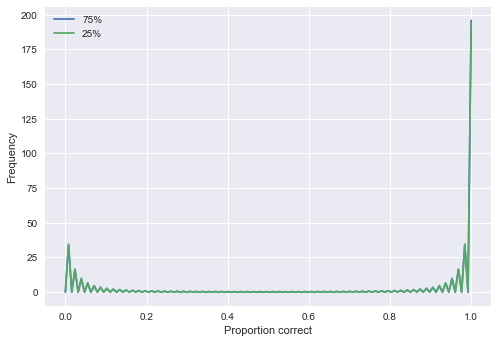

In [204]:
#RT 
rt_cond = sns.kdeplot((np.vstack(orient[0][:])[:,5]), label = "75%") #75%
rt_cond = sns.kdeplot((np.vstack(orient[1][:])[:,5]), label = "25%") #25%
rt_cond.set(xlabel='RT (s)', ylabel = 'Frequency')
plt.show()

acc_cond = sns.kdeplot((np.vstack(all_orient[0][:])[:,12]), label = "75%") #75%
acc_cond = sns.kdeplot((np.vstack(all_orient[1][:])[:,12]), label = "25%") #25%
acc_cond.set(xlabel='Proportion correct', ylabel = 'Frequency')
plt.show()

Now, if we look at the distribution of RT, this looks potentially longer than should be possible. This means I should check how psychoPy is recording RT (is it cued to the Key presentation!!). 